In [71]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
from scipy.stats import genextreme
from scipy.stats import weibull_min
import matplotlib.pyplot as plt

operating_system = 'mac'

if operating_system == 'win':
    os.chdir('C:/Users/fabau/OneDrive/Documents/GitHub/master-project-cleaned/')
elif operating_system == 'curnagl':
    os.chdir('/work/FAC/FGSE/IDYST/tbeucler/default/fabien/repos/cleaner_version/')
else:
    os.chdir('/Users/fabienaugsburger/Documents/GitHub/master-project-cleaned/')

# Add the path to the custom library
custom_library_path = os.path.abspath('util/processing/')
sys.path.append(custom_library_path)

import time_series

custom_library_path_2 = os.path.abspath('util/gev')
sys.path.append(custom_library_path_2)

import data_processing#, vgam_loader

'''if operating_system == 'curnagl':
    name_of_variable= pd.read_csv('/work/FAC/FGSE/IDYST/tbeucler/default/fabien/repos/curnagl/DATASETS/variable_list_80_mean.csv')
    path_data = '/work/FAC/FGSE/IDYST/tbeucler/default/fabien/repos/curnagl/DATASETS'
else:'''
name_of_variable= pd.read_csv('data/variable_list_levels.csv')
path_data = 'data'

storm_dates = pd.read_csv('pre_processing/tracks/storm_dates.csv')
path_tracks_1h = 'pre_processing/tracks/ALL_TRACKS/tracks_1h'
#path_tracks_1h_non_EU = 'pre_processing/tracks/ALL_TRACKS/tracks_1h_non_EU'
dataset = 'datasets_1h'
#dataset_non_EU = 'datasets_1h_non_EU'

In [4]:
print(sys.path)

['/Users/fabienaugsburger/Documents/GitHub/master-project-cleaned/pre_processing/GEV', '/Users/fabienaugsburger/anaconda3/envs/master/lib/python311.zip', '/Users/fabienaugsburger/anaconda3/envs/master/lib/python3.11', '/Users/fabienaugsburger/anaconda3/envs/master/lib/python3.11/lib-dynload', '', '/Users/fabienaugsburger/anaconda3/envs/master/lib/python3.11/site-packages', '/Users/fabienaugsburger/Documents/GitHub/master-project-cleaned/util/processing', '/Users/fabienaugsburger/Documents/GitHub/master-project-cleaned/util/gev', '/Users/fabienaugsburger/Documents/GitHub/master-project-cleaned/util/processing', '/Users/fabienaugsburger/Documents/GitHub/master-project-cleaned/util/gev', '/Users/fabienaugsburger/Documents/GitHub/master-project-cleaned/util/processing', '/Users/fabienaugsburger/Documents/GitHub/master-project-cleaned/util/gev']


In [2]:
# response value (or extreme value) taken from the storm landfall

vivian = time_series.tif_to_dataframe('data/time_series_rasters_storms_15h/5_VIVIAN.tif', '02_02_90')
climato_vivian = time_series.tif_to_dataframe('data/climatology/daily_without_storms/climatology_europe_2_2.tif', '02_02')

# drop rows with nan values
vivian = vivian.dropna()
climato_vivian = climato_vivian.dropna()

# wind values only
'''vivian = vivian.iloc[:,0]
climato_vivian = climato_vivian.iloc[:,0]
# export the frist column of each dataframe
vivian.to_csv('data/test/5_VIVIAN.csv')
climato_vivian.to_csv('data/test/max_winds_europe_2_2_cut.csv')'''

# Define latitude and longitude boundaries for Eastern and Southern Europe
lat_min, lat_max = 35, 75
lon_min, lon_max = -10, 25

# Filter the DataFrame based on these boundaries
vivian_small = vivian[(vivian['latitude'] >= lat_min) & (vivian['latitude'] <= lat_max) &
                 (vivian['longitude'] >= lon_min) & (vivian['longitude'] <= lon_max)]
climato_vivian_small = climato_vivian[(climato_vivian['latitude'] >= lat_min) & (climato_vivian['latitude'] <= lat_max) &
                    (climato_vivian['longitude'] >= lon_min) & (climato_vivian['longitude'] <= lon_max)]
# load the clean cluster data 
cluster_data = pd.read_csv('pre_processing/cluster/number_of_clusters/cleaned_cluster_15_v1.csv')

# Add the cluster number to the vivian_small DataFrame
for idx, row in vivian_small.iterrows():
    lat, lon = row['latitude'], row['longitude']
    vivian_small.loc[idx, 'cluster_n'] = \
        cluster_data.loc[(cluster_data['Latitude'] == lat) & (cluster_data['Longitude'] == lon), 'cluster_n'].values[0]
    
# Add the cluster number to the climato_vivian_small DataFrame
for idx, row in climato_vivian_small.iterrows():
    lat, lon = row['latitude'], row['longitude']
    climato_vivian_small.loc[idx, 'cluster_n'] = \
        cluster_data.loc[(cluster_data['Latitude'] == lat) & (cluster_data['Longitude'] == lon), 'cluster_n'].values[0]

/var/folders/01/5ryz4pnn581dj9gk6r1nn5qr0000gn/T/ipykernel_8770/1747927560.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vivian_small.loc[idx, 'cluster_n'] = \
/var/folders/01/5ryz4pnn581dj9gk6r1nn5qr0000gn/T/ipykernel_8770/1747927560.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  climato_vivian_small.loc[idx, 'cluster_n'] = \


Shape (ξ): 0.1890843670434622, Location (μ): 21.868480614147536, Scale (σ): 2.107041196823235


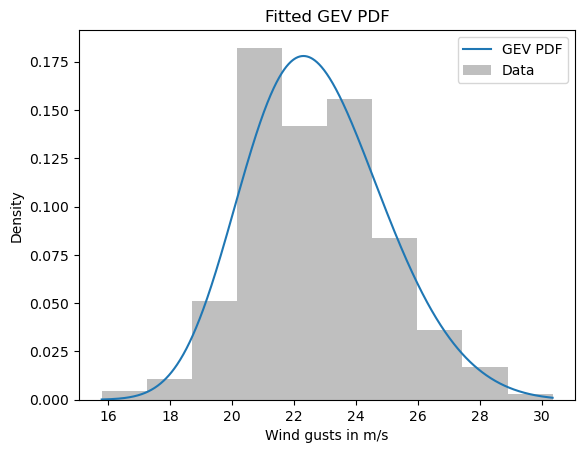

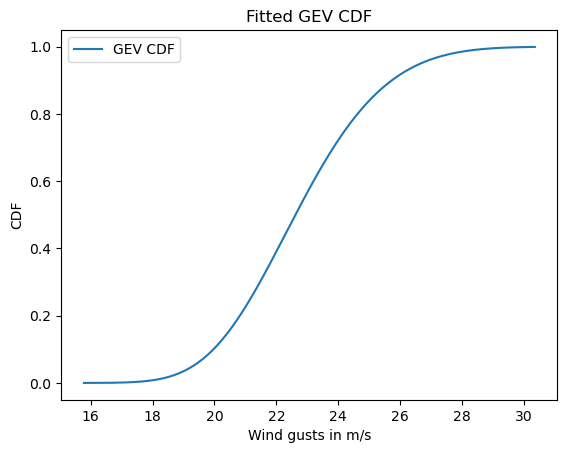

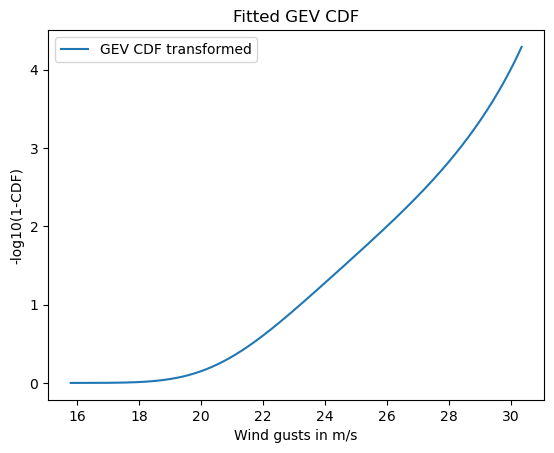

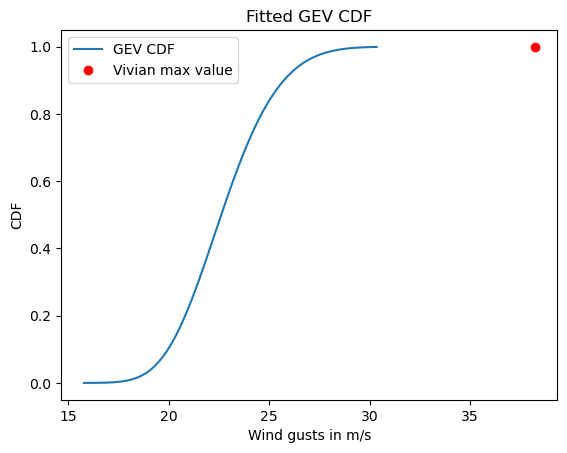

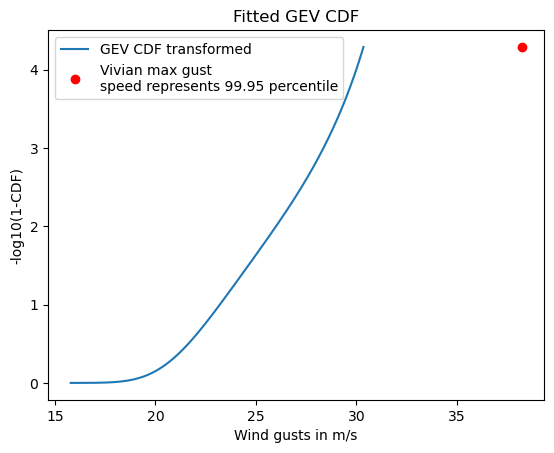

In [46]:
import numpy as np
from scipy.stats import genextreme
import matplotlib.pyplot as plt

# Example data: yearly maxima with cluster number 0
cluster_number = 3

data = climato_vivian_small.groupby('cluster_n')
data = data.get_group(cluster_number)['wind_speed_02_02']
vivian_subset = vivian_small[vivian_small['cluster_n'] == cluster_number]['wind_speed_02_02_90']

# Fit the GEV distribution
shape, loc, scale = genextreme.fit(data, method="MLE")

print(f"Shape (ξ): {shape}, Location (μ): {loc}, Scale (σ): {scale}")

# Plot the PDF

x_vals = np.linspace(min(data), max(data), 1000)
pdf_vals = genextreme.pdf(x_vals, shape, loc=loc, scale=scale)
cdf_vals = genextreme.cdf(x_vals, shape, loc=loc, scale=scale)

# tranform it with target - log10(1-CDF)
cdf_vals_tranformed = cdf_vals-np.log10(1-cdf_vals)

plt.plot(x_vals, pdf_vals, label="GEV PDF")
plt.hist(data, bins=10, density=True, alpha=0.5, color="gray", label="Data")
plt.legend()
plt.title("Fitted GEV PDF")
plt.xlabel("Wind gusts in m/s")
plt.ylabel("Density")
plt.show()

# Plot the CDF
plt.plot(x_vals, cdf_vals, label="GEV CDF")
plt.legend()
plt.title("Fitted GEV CDF")
plt.xlabel("Wind gusts in m/s")
plt.ylabel("CDF")
plt.show()


plt.plot(x_vals, cdf_vals_tranformed, label="GEV CDF transformed")
plt.legend()
plt.title("Fitted GEV CDF")
plt.xlabel("Wind gusts in m/s")
plt.ylabel("-log10(1-CDF)")
plt.show()

# find the max value of the storm data (Vivian)
max_vivian = vivian_subset.max()

# find to what percentile the max_vivian value corresponds in the GEV distribution
percentile_CDF = cdf_vals[np.argmin(np.abs(x_vals - max_vivian))]
percentile_CDF_transformed = cdf_vals_tranformed[np.argmin(np.abs(x_vals - max_vivian))]

# plot them on the CDF and CDF transformed
plt.plot(x_vals, cdf_vals, label="GEV CDF")
plt.plot(max_vivian, percentile_CDF, 'ro', label="Vivian max value")
plt.legend()
plt.title("Fitted GEV CDF")
plt.xlabel("Wind gusts in m/s")
plt.ylabel("CDF")
plt.show()

plt.plot(x_vals, cdf_vals_tranformed, label="GEV CDF transformed")
plt.plot(max_vivian, percentile_CDF_transformed, 'ro', label=f"Vivian max gust\nspeed represents {percentile_CDF*100:.2f} percentile")
plt.legend()
plt.title("Fitted GEV CDF")
plt.xlabel("Wind gusts in m/s")
plt.ylabel("-log10(1-CDF)")
plt.show()

Cluster number: 0
Shape (ξ): 0.18141472036310008, Location (μ): 20.702205615905925, Scale (σ): 1.4698744394384435
Max Vivian Wind Gust: 34.298316129702584 m/s


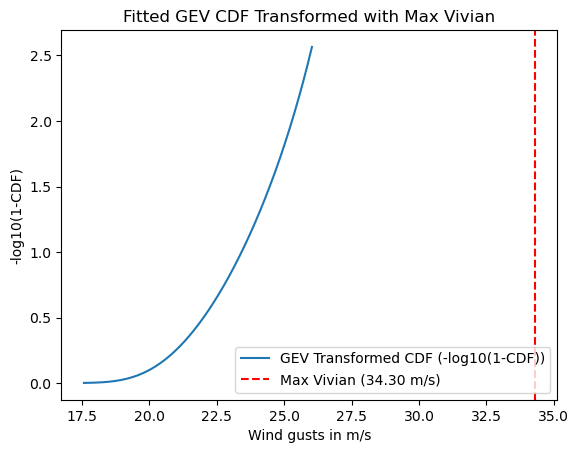

Return Period of Max Vivian Wind Gust: inf years
Cluster number: 1
Shape (ξ): 0.11612598342162322, Location (μ): 19.955200168637298, Scale (σ): 1.6825143299767884
Max Vivian Wind Gust: 33.75238426429628 m/s


/var/folders/01/5ryz4pnn581dj9gk6r1nn5qr0000gn/T/ipykernel_8770/3687254706.py:52: RuntimeWarning: divide by zero encountered in scalar divide
  return_period = 1 / (1 - cdf_max_vivian)


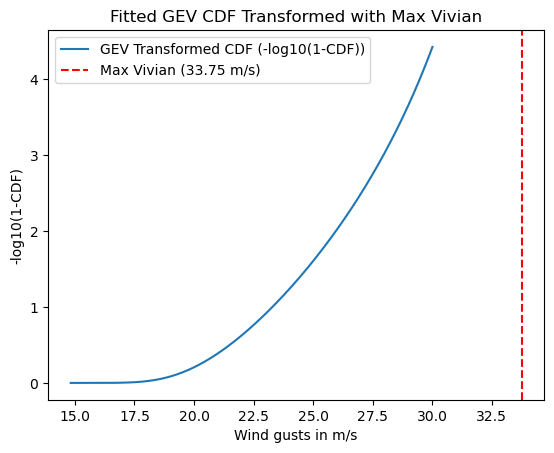

Return Period of Max Vivian Wind Gust: 238531798806.73 years
Cluster number: 2
Shape (ξ): -0.19783174819466295, Location (μ): 22.890531391724746, Scale (σ): 5.689100785070862
Max Vivian Wind Gust: 19.258854679788445 m/s


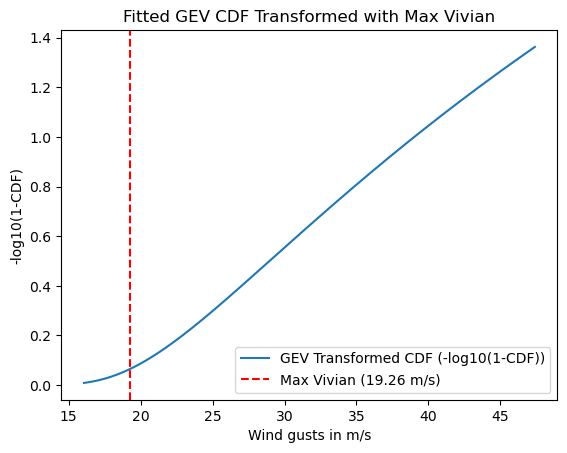

Return Period of Max Vivian Wind Gust: 1.16 years
Cluster number: 3
Shape (ξ): 0.1890843670434622, Location (μ): 21.868480614147536, Scale (σ): 2.107041196823235
Max Vivian Wind Gust: 38.22601582905756 m/s


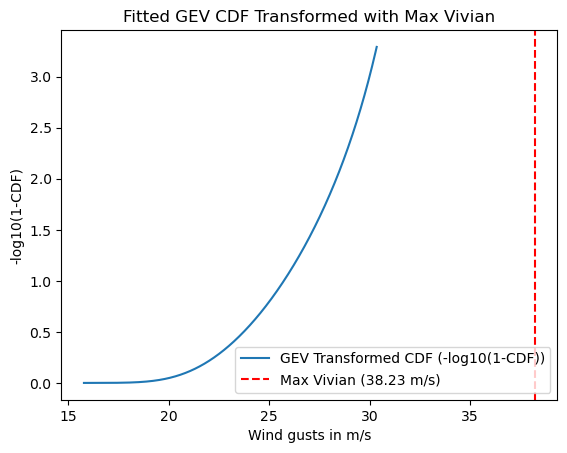

Return Period of Max Vivian Wind Gust: inf years
Cluster number: 4
Shape (ξ): 0.0404206445384844, Location (μ): 19.153684118047842, Scale (σ): 1.3453245688380733
Max Vivian Wind Gust: 24.28176225614534 m/s


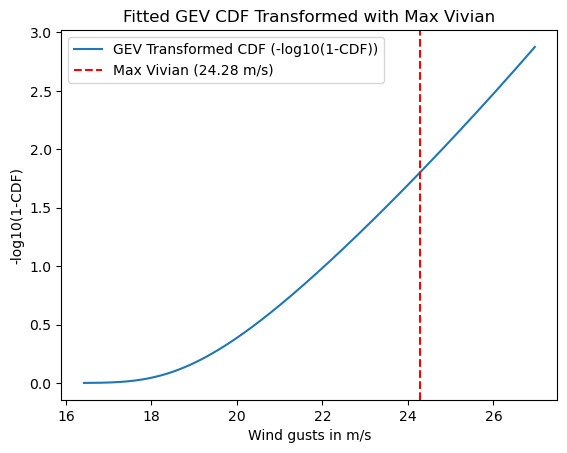

Return Period of Max Vivian Wind Gust: 63.28 years
Cluster number: 5
Shape (ξ): 0.22811279978723897, Location (μ): 21.62706520715929, Scale (σ): 4.148838213972128
Max Vivian Wind Gust: 22.349681795266378 m/s


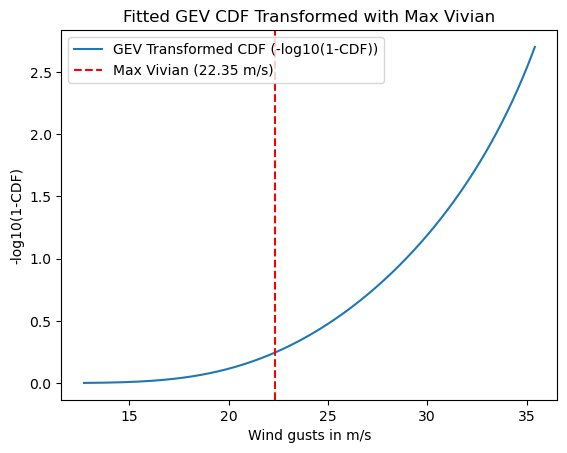

Return Period of Max Vivian Wind Gust: 1.76 years
Cluster number: 6
Shape (ξ): 0.13631561695063776, Location (μ): 28.478554587846205, Scale (σ): 2.559851064093988
Max Vivian Wind Gust: 41.357808735354645 m/s


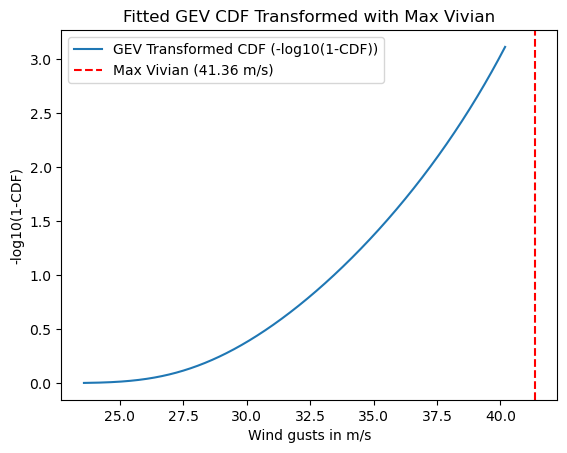

Return Period of Max Vivian Wind Gust: 4885.23 years
Cluster number: 7
Shape (ξ): 0.46584668317317984, Location (μ): 20.86121311065075, Scale (σ): 4.62502568248714
Max Vivian Wind Gust: 20.866552960303476 m/s


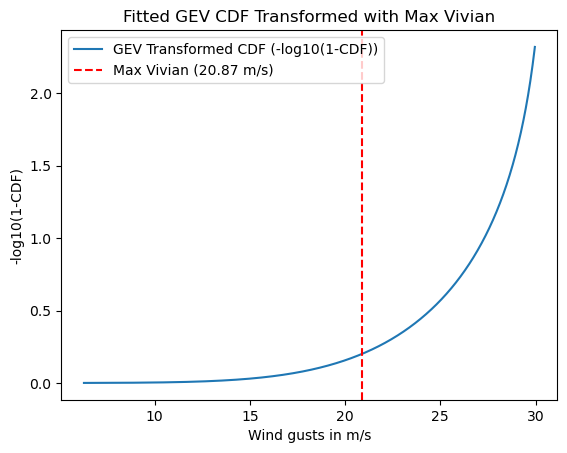

Return Period of Max Vivian Wind Gust: 1.58 years
Cluster number: 8
Shape (ξ): 0.19933047992257755, Location (μ): 16.706057222317263, Scale (σ): 2.882299945578085
Max Vivian Wind Gust: 21.190099104120073 m/s


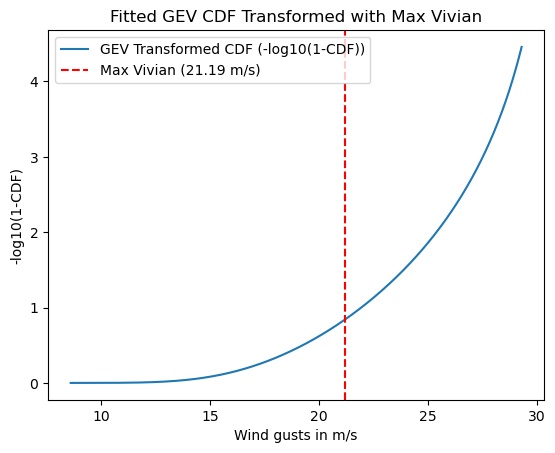

Return Period of Max Vivian Wind Gust: 6.95 years
Cluster number: 9
Shape (ξ): 0.09011051185802074, Location (μ): 21.38641636109024, Scale (σ): 2.0610503655485966
Max Vivian Wind Gust: 14.108033511690108 m/s


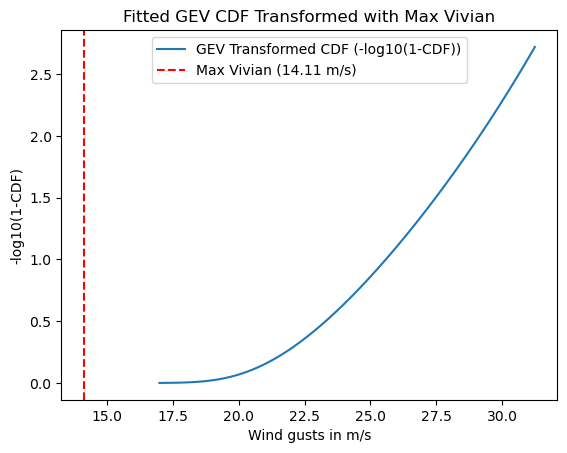

Return Period of Max Vivian Wind Gust: 1.00 years
Cluster number: 10
Shape (ξ): -0.23899428517843724, Location (μ): 19.14741305886404, Scale (σ): 2.3299939632823254
Max Vivian Wind Gust: 18.722119216402774 m/s


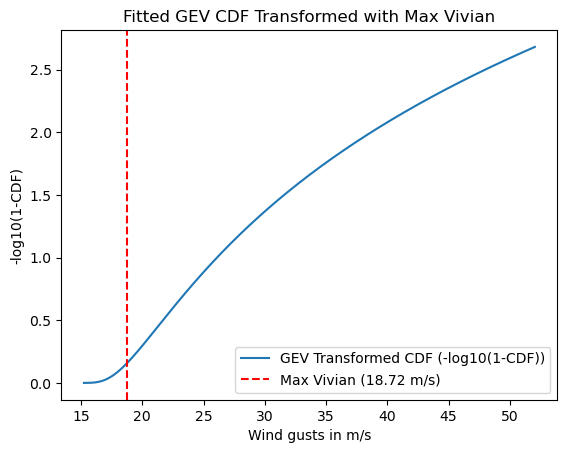

Return Period of Max Vivian Wind Gust: 1.43 years
Cluster number: 11
Shape (ξ): -0.0261144938313368, Location (μ): 25.78865991273984, Scale (σ): 3.9126564105787516
Max Vivian Wind Gust: 21.553775002208496 m/s


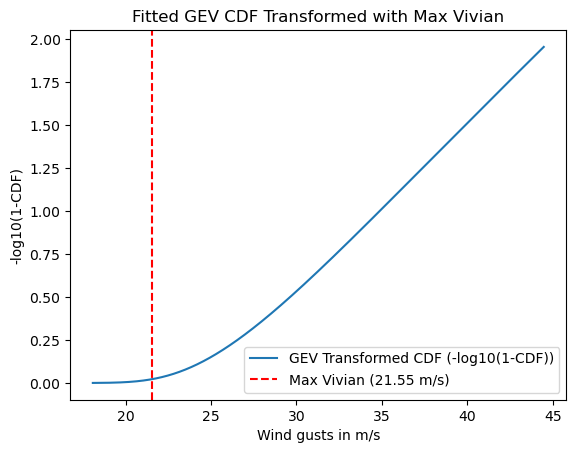

Return Period of Max Vivian Wind Gust: 1.05 years
Cluster number: 12
Shape (ξ): 0.24809232171845713, Location (μ): 28.575387528135934, Scale (σ): 5.242502087711989
Max Vivian Wind Gust: 27.908488798461615 m/s


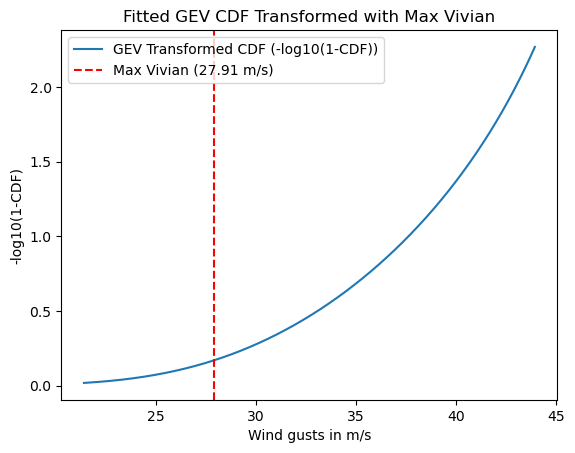

Return Period of Max Vivian Wind Gust: 1.47 years
Cluster number: 13
Shape (ξ): 2.5319377059301376, Location (μ): 29.5194842700934, Scale (σ): 2.5933680680405495
Max Vivian Wind Gust: 21.983497787535967 m/s


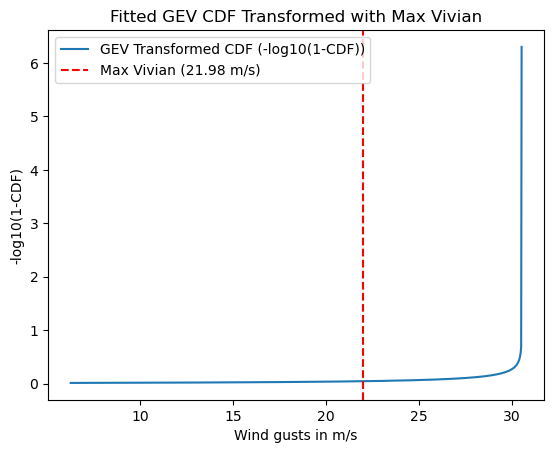

Return Period of Max Vivian Wind Gust: 1.11 years
Cluster number: 14
Shape (ξ): 0.029043941039239782, Location (μ): 23.693871607632083, Scale (σ): 3.113675988784606
Max Vivian Wind Gust: 19.999583060722568 m/s


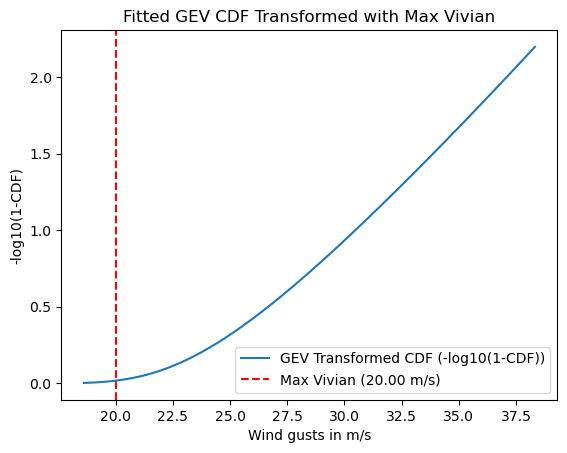

Return Period of Max Vivian Wind Gust: 1.04 years


In [7]:
import numpy as np
from scipy.stats import genextreme
import matplotlib.pyplot as plt

all_plot = 'no'

# Example data: yearly maxima with cluster number 0
cluster_numbers = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
for cluster_number in cluster_numbers:
    print('Cluster number:', cluster_number)
    data = climato_vivian_small.groupby('cluster_n')
    data = data.get_group(cluster_number)['wind_speed_02_02']
    vivian_subset = vivian_small[vivian_small['cluster_n'] == cluster_number]['wind_speed_02_02_90']

    # Fit the GEV distribution
    shape, loc, scale = genextreme.fit(data, method="MLE")

    print(f"Shape (ξ): {shape}, Location (μ): {loc}, Scale (σ): {scale}")

    # Max value of Vivian storm
    max_vivian = vivian_subset.max()
    print(f"Max Vivian Wind Gust: {max_vivian} m/s")

    # Plot the PDF
    x_vals = np.linspace(min(data), max(data), 1000)
    pdf_vals = genextreme.pdf(x_vals, shape, loc=loc, scale=scale)
    cdf_vals = genextreme.cdf(x_vals, shape, loc=loc, scale=scale)

    # Transform CDF to -log10(1-CDF)
    cdf_vals_transformed = -np.log10(1 - cdf_vals)
    if all_plot == 'yes':
        plt.plot(x_vals, pdf_vals, label="GEV PDF")
        plt.hist(data, bins=10, density=True, alpha=0.5, color="gray", label="Data")
        plt.axvline(max_vivian, color='red', linestyle='--', label=f"Max Vivian ({max_vivian:.2f} m/s)")
        plt.legend()
        plt.title("Fitted GEV PDF with Max Vivian")
        plt.xlabel("Wind gusts in m/s")
        plt.ylabel("Density")
        plt.show()

    # Plot the transformed CDF
    plt.plot(x_vals, cdf_vals_transformed, label="GEV Transformed CDF (-log10(1-CDF))")
    plt.axvline(max_vivian, color='red', linestyle='--', label=f"Max Vivian ({max_vivian:.2f} m/s)")
    plt.legend()
    plt.title("Fitted GEV CDF Transformed with Max Vivian")
    plt.xlabel("Wind gusts in m/s")
    plt.ylabel("-log10(1-CDF)")
    plt.show()

    # Compute return period for max_vivian
    cdf_max_vivian = genextreme.cdf(max_vivian, shape, loc=loc, scale=scale)
    return_period = 1 / (1 - cdf_max_vivian)
    print(f"Return Period of Max Vivian Wind Gust: {return_period:.2f} years")

In [45]:
test = xr.open_dataset('data/climatology/hourly_with_storms/climatology_europe_2_2.nc')
hourly_all = []
for i in range(0,24):
    test_test = test.sel(hour=i).to_dataframe().dropna()
    test_test = test_test.drop(columns=['hour', 'spatial_ref', 'band'])
    test_test = test_test.stack().reset_index()
    test_test = test_test.drop(columns=['level_2'])

    # Define latitude and longitude boundaries for Eastern and Southern Europe
    lat_min, lat_max = 35, 75
    lon_min, lon_max = -10, 25

    # Filter the DataFrame based on these boundaries

    test_test = test_test[(test_test['latitude'] >= lat_min) & (test_test['latitude'] <= lat_max) &
                        (test_test['longitude'] >= lon_min) & (test_test['longitude'] <= lon_max)]
    for idx, row in test_test.iterrows():
        lat, lon = row['latitude'], row['longitude']
        test_test.loc[idx, 'cluster_n'] = \
            cluster_data.loc[(cluster_data['Latitude'] == lat) & (cluster_data['Longitude'] == lon), 'cluster_n'].values[0]
    hourly_all.append(test_test)
# Concatenate all DataFrames in the list into a single DataFrame
hourly_all_df = pd.concat(hourly_all, ignore_index=True)

# rename the column 0 by wind_speed_02_02
hourly_all_df_with = hourly_all_df.rename(columns={0: 'wind_speed_02_02'})
hourly_all_df_with['name'] = 'hourly_with_storms'

In [9]:
import pandas as pd
import xarray as xr

def process_hourly_climatology(dataset_path, cluster_data, name, lat_min=35, lat_max=75, lon_min=-10, lon_max=25):
    """
    Processes hourly climatology data and assigns cluster information.

    Parameters:
        dataset_path (str): Path to the NetCDF dataset.
        cluster_data (pd.DataFrame): DataFrame containing cluster data with 'Latitude', 'Longitude', and 'cluster_n' columns.
        name (str): Name to assign to the processed data (e.g., 'hourly_with_storms').
        lat_min (float): Minimum latitude boundary for filtering data.
        lat_max (float): Maximum latitude boundary for filtering data.
        lon_min (float): Minimum longitude boundary for filtering data.
        lon_max (float): Maximum longitude boundary for filtering data.

    Returns:
        pd.DataFrame: Processed DataFrame with wind speed and cluster information.
    """
    # Open dataset
    test = xr.open_dataset(dataset_path)
    hourly_all = []

    for i in range(24):
        # Select data for the current hour and preprocess
        test_test = test.sel(hour=i).to_dataframe().dropna()
        test_test = test_test.drop(columns=['hour', 'spatial_ref', 'band'])
        test_test = test_test.stack().reset_index()
        test_test = test_test.drop(columns=['level_2'])

        # Filter by latitude and longitude boundaries
        test_test = test_test[
            (test_test['latitude'] >= lat_min) & (test_test['latitude'] <= lat_max) &
            (test_test['longitude'] >= lon_min) & (test_test['longitude'] <= lon_max)
        ]

        # Add cluster number
        for idx, row in test_test.iterrows():
            lat, lon = row['latitude'], row['longitude']
            cluster_value = cluster_data.loc[
                (cluster_data['Latitude'] == lat) & (cluster_data['Longitude'] == lon), 'cluster_n'
            ]
            if not cluster_value.empty:
                test_test.loc[idx, 'cluster_n'] = cluster_value.values[0]

        hourly_all.append(test_test)

    # Concatenate all DataFrames
    hourly_all_df = pd.concat(hourly_all, ignore_index=True)

    # Rename column and add the provided name
    hourly_all_df_with = hourly_all_df.rename(columns={0: 'wind_speed_None'})
    hourly_all_df_with['name'] = name

    return hourly_all_df_with

In [10]:
# Assuming 'cluster_data' is already loaded as a DataFrame
dataset_path = 'data/climatology/hourly_without_storms/climatology_europe_2_2.nc'
test = process_hourly_climatology(dataset_path, cluster_data, name='hourly_without_storms')

In [55]:
test = xr.open_dataset('data/climatology/hourly_without_storms/climatology_europe_2_2.nc')
hourly_all = []
for i in range(0,24):
    test_test = test.sel(hour=i).to_dataframe().dropna()
    test_test = test_test.drop(columns=['hour', 'spatial_ref', 'band'])
    test_test = test_test.stack().reset_index()
    test_test = test_test.drop(columns=['level_2'])

    # Define latitude and longitude boundaries for Eastern and Southern Europe
    lat_min, lat_max = 35, 75
    lon_min, lon_max = -10, 25

    # Filter the DataFrame based on these boundaries

    test_test = test_test[(test_test['latitude'] >= lat_min) & (test_test['latitude'] <= lat_max) &
                        (test_test['longitude'] >= lon_min) & (test_test['longitude'] <= lon_max)]
    for idx, row in test_test.iterrows():
        lat, lon = row['latitude'], row['longitude']
        test_test.loc[idx, 'cluster_n'] = \
            cluster_data.loc[(cluster_data['Latitude'] == lat) & (cluster_data['Longitude'] == lon), 'cluster_n'].values[0]
    hourly_all.append(test_test)
# Concatenate all DataFrames in the list into a single DataFrame
hourly_all_df = pd.concat(hourly_all, ignore_index=True)

# rename the column 0 by wind_speed_02_02
hourly_all_df_without = hourly_all_df.rename(columns={0: 'wind_speed_02_02'})

hourly_all_df_without['name'] = 'hourly_without_storms'

In [7]:
import pandas as pd

def process_daily_climatology(file_path, cluster_data, name, lat_min=35, lat_max=75, lon_min=-10, lon_max=25):
    """
    Processes daily climatology data and assigns cluster information.

    Parameters:
        file_path (str): Path to the TIFF file containing climatology data.
        cluster_data (pd.DataFrame): DataFrame containing cluster data with 'Latitude', 'Longitude', and 'cluster_n' columns.
        name (str): Name to assign to the processed data (e.g., 'daily_with_storms', 'daily_without_storms').
        lat_min (float): Minimum latitude boundary for filtering data.
        lat_max (float): Maximum latitude boundary for filtering data.
        lon_min (float): Minimum longitude boundary for filtering data.
        lon_max (float): Maximum longitude boundary for filtering data.

    Returns:
        pd.DataFrame: Processed DataFrame with cluster information.
    """
    # Load climatology data
    climatology_df = time_series.tif_to_dataframe(file_path)#, '02_02')
    climatology_df = climatology_df.dropna()

    # Filter by latitude and longitude boundaries
    climatology_df = climatology_df[
        (climatology_df['latitude'] >= lat_min) & (climatology_df['latitude'] <= lat_max) &
        (climatology_df['longitude'] >= lon_min) & (climatology_df['longitude'] <= lon_max)
    ]

    # Add cluster number
    for idx, row in climatology_df.iterrows():
        lat, lon = row['latitude'], row['longitude']
        cluster_value = cluster_data.loc[
            (cluster_data['Latitude'] == lat) & (cluster_data['Longitude'] == lon), 'cluster_n'
        ]
        if not cluster_value.empty:
            climatology_df.loc[idx, 'cluster_n'] = cluster_value.values[0]

    # Assign name
    climatology_df['name'] = name

    return climatology_df

In [8]:
# Paths to the climatology data
file_path = 'data/climatology/daily_with_storms/climatology_europe_2_2.tif'

# Load cluster data as a DataFrame
cluster_data = pd.read_csv('pre_processing/cluster/number_of_clusters/cleaned_cluster_15_v1.csv')

# Process data for daily_with_storms
test_2 = process_daily_climatology(
    file_path, cluster_data, name='daily_with_storms'
)

/var/folders/01/5ryz4pnn581dj9gk6r1nn5qr0000gn/T/ipykernel_8770/2777266924.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  climato_vivian_small_without_storms.loc[idx, 'cluster_n'] = \
/var/folders/01/5ryz4pnn581dj9gk6r1nn5qr0000gn/T/ipykernel_8770/2777266924.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  climato_vivian_small_with_storms.loc[idx, 'cluster_n'] = \


Cluster number: 3
Shape (ξ): 0.1890843670434622, Location (μ): 21.868480614147536, Scale (σ): 2.107041196823235
Max Vivian Wind Gust: 38.22601582905756 m/s


/var/folders/01/5ryz4pnn581dj9gk6r1nn5qr0000gn/T/ipykernel_8770/2777266924.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  climato_vivian_small_with_storms['name'] = 'daily_with_storms'
/var/folders/01/5ryz4pnn581dj9gk6r1nn5qr0000gn/T/ipykernel_8770/2777266924.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  climato_vivian_small_without_storms['name'] = 'daily_without_storms'


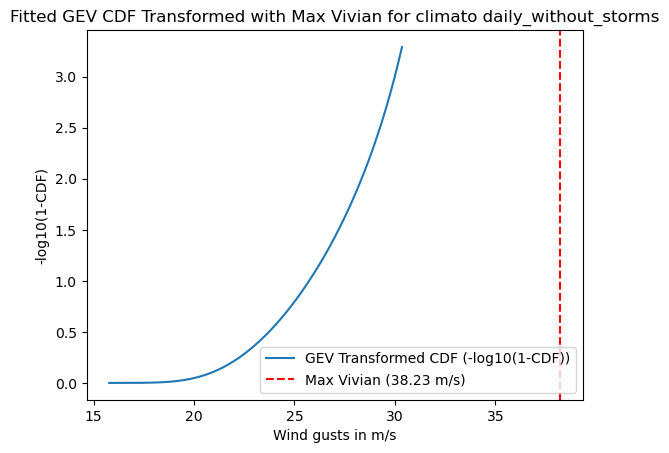

/var/folders/01/5ryz4pnn581dj9gk6r1nn5qr0000gn/T/ipykernel_8770/2777266924.py:97: RuntimeWarning: divide by zero encountered in scalar divide
  return_period = 1 / (1 - cdf_max_vivian)


Return Period of Max Vivian Wind Gust: inf years
Cluster number: 3
Shape (ξ): 0.3294756591162554, Location (μ): 25.397486488921807, Scale (σ): 3.363615723016351
Max Vivian Wind Gust: 38.22601582905756 m/s


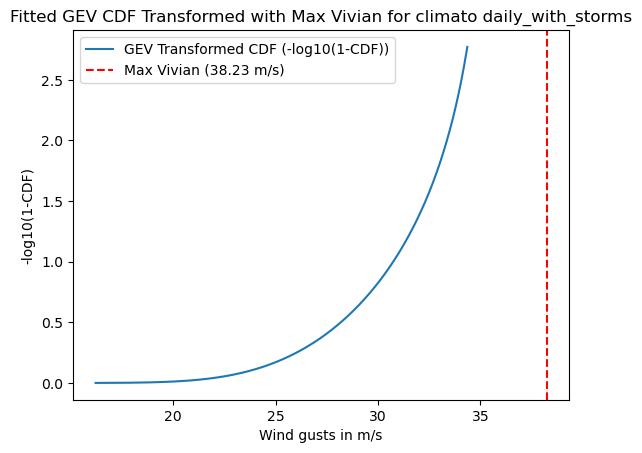

Return Period of Max Vivian Wind Gust: inf years
Cluster number: 3
Shape (ξ): 0.1608528101264684, Location (μ): 18.669109728351636, Scale (σ): 3.3956253689812095
Max Vivian Wind Gust: 38.22601582905756 m/s


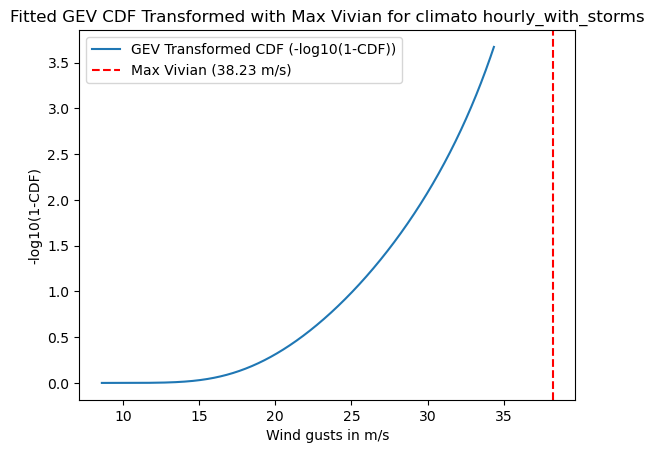

Return Period of Max Vivian Wind Gust: 11099080.36 years
Cluster number: 3
Shape (ξ): 0.20839599819832832, Location (μ): 17.539917280086982, Scale (σ): 2.8185461764971356
Max Vivian Wind Gust: 38.22601582905756 m/s


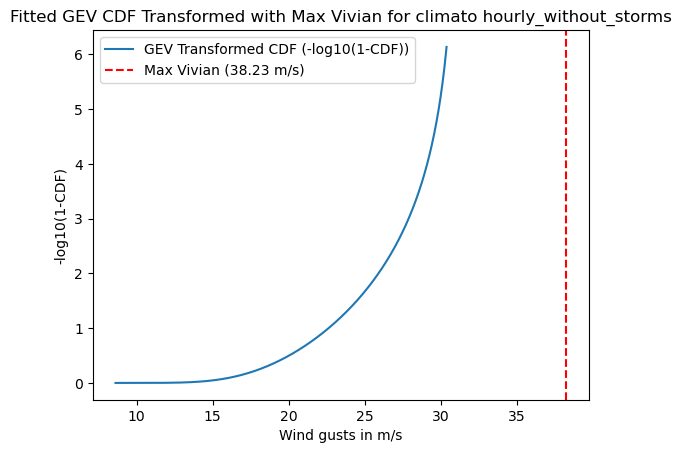

Return Period of Max Vivian Wind Gust: inf years


In [56]:
import numpy as np
from scipy.stats import genextreme
import matplotlib.pyplot as plt

all_plot = 'no'

# response value (or extreme value) taken from the storm landfall

climato_vivian_without_storms = time_series.tif_to_dataframe('data/climatology/daily_without_storms/climatology_europe_2_2.tif', '02_02')
climato_vivian_with_storms = time_series.tif_to_dataframe('data/climatology/daily_with_storms/climatology_europe_2_2.tif', '02_02')

# drop rows with nan values
climato_vivian_without_storms = climato_vivian_without_storms.dropna()
climato_vivian_with_storms = climato_vivian_with_storms.dropna()

# Define latitude and longitude boundaries for Eastern and Southern Europe
lat_min, lat_max = 35, 75
lon_min, lon_max = -10, 25

# Filter the DataFrame based on these boundaries

climato_vivian_small_without_storms = climato_vivian_without_storms[(climato_vivian_without_storms['latitude'] >= lat_min) & (climato_vivian_without_storms['latitude'] <= lat_max) &
                    (climato_vivian_without_storms['longitude'] >= lon_min) & (climato_vivian_without_storms['longitude'] <= lon_max)]
climato_vivian_small_with_storms = climato_vivian_with_storms[(climato_vivian_with_storms['latitude'] >= lat_min) & (climato_vivian_with_storms['latitude'] <= lat_max) &
                    (climato_vivian_with_storms['longitude'] >= lon_min) & (climato_vivian_with_storms['longitude'] <= lon_max)]

# load the clean cluster data 
cluster_data = pd.read_csv('pre_processing/cluster/number_of_clusters/cleaned_cluster_15_v1.csv')

# Add the cluster number to the climato_vivian_small DataFrame
for idx, row in climato_vivian_small_without_storms.iterrows():
    lat, lon = row['latitude'], row['longitude']
    climato_vivian_small_without_storms.loc[idx, 'cluster_n'] = \
        cluster_data.loc[(cluster_data['Latitude'] == lat) & (cluster_data['Longitude'] == lon), 'cluster_n'].values[0]
for idx, row in climato_vivian_small_with_storms.iterrows():
    lat, lon = row['latitude'], row['longitude']
    climato_vivian_small_with_storms.loc[idx, 'cluster_n'] = \
        cluster_data.loc[(cluster_data['Latitude'] == lat) & (cluster_data['Longitude'] == lon), 'cluster_n'].values[0]

climato_vivian_small_with_storms['name'] = 'daily_with_storms'
climato_vivian_small_without_storms['name'] = 'daily_without_storms'

dataset = []
dataset.append(climato_vivian_small_without_storms)
dataset.append(climato_vivian_small_with_storms)
dataset.append(hourly_all_df_with)
dataset.append(hourly_all_df_without)


# Example data: yearly maxima with cluster number 0
cluster_number = 3
for data in dataset:
    data_name = data['name'].iloc[0]
    print('Cluster number:', cluster_number)
    data = data.groupby('cluster_n')
    data = data.get_group(cluster_number)['wind_speed_02_02']
    vivian_subset = vivian_small[vivian_small['cluster_n'] == cluster_number]['wind_speed_02_02_90']

    # Fit the GEV distribution
    shape, loc, scale = genextreme.fit(data, method="MLE")

    print(f"Shape (ξ): {shape}, Location (μ): {loc}, Scale (σ): {scale}")

    # Max value of Vivian storm
    max_vivian = vivian_subset.max()
    print(f"Max Vivian Wind Gust: {max_vivian} m/s")

    # Plot the PDF
    x_vals = np.linspace(min(data), max(data), 1000)
    pdf_vals = genextreme.pdf(x_vals, shape, loc=loc, scale=scale)
    cdf_vals = genextreme.cdf(x_vals, shape, loc=loc, scale=scale)

    # Transform CDF to -log10(1-CDF)
    cdf_vals_transformed = -np.log10(1 - cdf_vals)
    if all_plot == 'yes':
        plt.plot(x_vals, pdf_vals, label="GEV PDF")
        plt.hist(data, bins=10, density=True, alpha=0.5, color="gray", label="Data")
        plt.axvline(max_vivian, color='red', linestyle='--', label=f"Max Vivian ({max_vivian:.2f} m/s)")
        plt.legend()
        plt.title("Fitted GEV PDF with Max Vivian")
        plt.xlabel("Wind gusts in m/s")
        plt.ylabel("Density")
        plt.show()

    # Plot the transformed CDF
    plt.plot(x_vals, cdf_vals_transformed, label="GEV Transformed CDF (-log10(1-CDF))")
    plt.axvline(max_vivian, color='red', linestyle='--', label=f"Max Vivian ({max_vivian:.2f} m/s)")
    plt.legend()
    plt.title(f"Fitted GEV CDF Transformed with Max Vivian for climato {data_name}")
    plt.xlabel("Wind gusts in m/s")
    plt.ylabel("-log10(1-CDF)")
    plt.savefig(f'pre_processing/GEV/figures/gev_transformed_{data_name}.png')
    plt.show()

    # Compute return period for max_vivian
    cdf_max_vivian = genextreme.cdf(max_vivian, shape, loc=loc, scale=scale)
    return_period = 1 / (1 - cdf_max_vivian)
    print(f"Return Period of Max Vivian Wind Gust: {return_period:.2f} years")

In [ ]:
# now calculate the moving location with climatology 1 day before and 1 day after the storm



/var/folders/01/5ryz4pnn581dj9gk6r1nn5qr0000gn/T/ipykernel_1619/974471234.py:5: RuntimeWarning: divide by zero encountered in log10
  cdf_vals_tranformed_extended = cdf_vals_extended-np.log10(1-cdf_vals_extended)


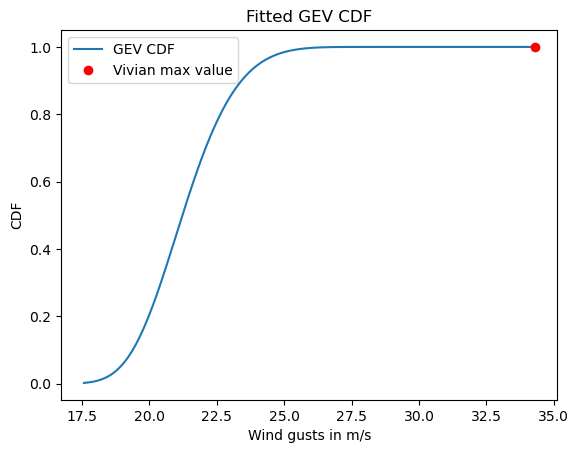

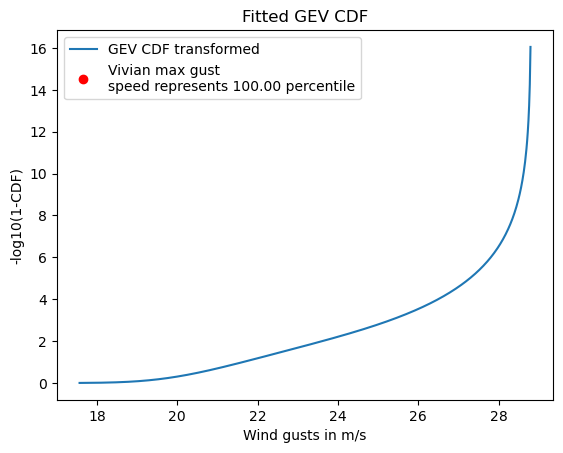

In [36]:
# now expand the x_vals to the whole range of the maxima
x_vals_extended = np.linspace(min(data), max(vivian_subset), 1000)
cdf_vals_extended = genextreme.cdf(x_vals_extended, shape, loc=loc, scale=scale)
# tranform it with target - log10(1-CDF)
cdf_vals_tranformed_extended = cdf_vals_extended-np.log10(1-cdf_vals_extended)

percentile_extended = cdf_vals_extended[np.argmin(np.abs(x_vals_extended - max_vivian))]
percentile_CDF_transformed_extended = cdf_vals_tranformed_extended[np.argmin(np.abs(x_vals_extended - max_vivian))]

# plot them on the CDF and CDF transformed
plt.plot(x_vals_extended, cdf_vals_extended, label="GEV CDF")
plt.plot(max_vivian, percentile_extended, 'ro', label="Vivian max value")
plt.legend()
plt.title("Fitted GEV CDF")
plt.xlabel("Wind gusts in m/s")
plt.ylabel("CDF")
plt.show()

plt.plot(x_vals_extended, cdf_vals_tranformed_extended, label="GEV CDF transformed")
plt.plot(max_vivian, percentile_CDF_transformed_extended, 'ro', label=f"Vivian max gust\nspeed represents {percentile_extended*100:.2f} percentile")
plt.legend()
plt.title("Fitted GEV CDF")
plt.xlabel("Wind gusts in m/s")
plt.ylabel("-log10(1-CDF)")
plt.show()

In [33]:
# calculate the return period of the storm
return_period = 1/(1-percentile_extended)
print(f"The return period of the storm Vivian is {return_period:.2f} years")

The return period of the storm Vivian is inf years


/var/folders/01/5ryz4pnn581dj9gk6r1nn5qr0000gn/T/ipykernel_1619/963461105.py:2: RuntimeWarning: divide by zero encountered in scalar divide
  return_period = 1/(1-percentile_extended)


In [49]:
# import cluster data 
cluster_data = pd.read_csv('pre_processing/cluster/number_of_clusters/cleaned_cluster_15_v1.csv')
paths = ['hourly_with_storms', 'hourly_without_storms', 'daily_with_storms', 'daily_without_storms']
all_datasets = []
months = [1,2]
days = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31]
for path in paths:
    if path == 'hourly_with_storms' or path =='hourly_without_storms':
        file_path_2_2 = f'data/climatology/{path}/climatology_europe_2_2.nc'
        file_path_2_1 = f'data/climatology/{path}/climatology_europe_2_1.nc'
        file_path_2_3 = f'data/climatology/{path}/climatology_europe_2_3.nc'
        hourly_2_2 = data_processing.process_hourly_climatology(
            file_path_2_2, cluster_data, name=path
        )
        all_datasets.append(hourly_2_2)
        hourly_2_1 = data_processing.process_hourly_climatology(
            file_path_2_1, cluster_data, name=path
        )
        all_datasets.append(hourly_2_1)
        hourly_2_3 = data_processing.process_hourly_climatology(
            file_path_2_3, cluster_data, name=path
        )
        all_datasets.append(hourly_2_3)
    elif path == 'daily_with_storms' or path =='daily_without_storms':
        file_path_2_2 = f'data/climatology/{path}/climatology_europe_2_2.tif'
        file_path_2_1 = f'data/climatology/{path}/climatology_europe_2_1.tif'
        file_path_2_3 = f'data/climatology/{path}/climatology_europe_2_3.tif'

        # Process data for daily_with_storms
        daily_2_2 = data_processing.process_daily_climatology(
            file_path_2_2, cluster_data, name=path
        )
        all_datasets.append(daily_2_2)
        daily_2_1 = data_processing.process_daily_climatology(
            file_path_2_1, cluster_data, name=path
        )
        all_datasets.append(daily_2_1)
        daily_2_3 = data_processing.process_daily_climatology(
            file_path_2_3, cluster_data, name=path
        )
        all_datasets.append(daily_2_3)

In [17]:
cluster_data_original = pd.read_csv('pre_processing/cluster/number_of_clusters/cleaned_cluster_15_v1.csv')

vivian = data_processing.process_daily_climatology('data/time_series_rasters_storms_15h/5_VIVIAN.tif', cluster_data_original, 'VIVIAN')

Cluster number: 3
Data: hourly_with_storms
Shape (ξ): 0.1608528101264684, Location (μ): 18.669109728351636, Scale (σ): 3.3956253689812095
Cluster number: 3
Data: hourly_with_storms
Shape (ξ): 0.2580630910216394, Location (μ): 18.258493215954253, Scale (σ): 3.3425825156343554
Cluster number: 3
Data: hourly_with_storms
Shape (ξ): 0.06926814039415291, Location (μ): 18.64746541248495, Scale (σ): 2.9685801052078595
Cluster number: 3
Data: hourly_without_storms
Shape (ξ): 0.20839599819832832, Location (μ): 17.539917280086982, Scale (σ): 2.8185461764971356
Cluster number: 3
Data: hourly_without_storms
Shape (ξ): 0.23805537111735614, Location (μ): 17.78650525468617, Scale (σ): 3.2288704754603987
Cluster number: 3
Data: hourly_without_storms
Shape (ξ): 0.12168508878996503, Location (μ): 17.70556875848546, Scale (σ): 2.6224533525251834
Cluster number: 3
Data: daily_with_storms
Shape (ξ): 0.3294756591162554, Location (μ): 25.397486488921807, Scale (σ): 3.363615723016351
Cluster number: 3
Data: da

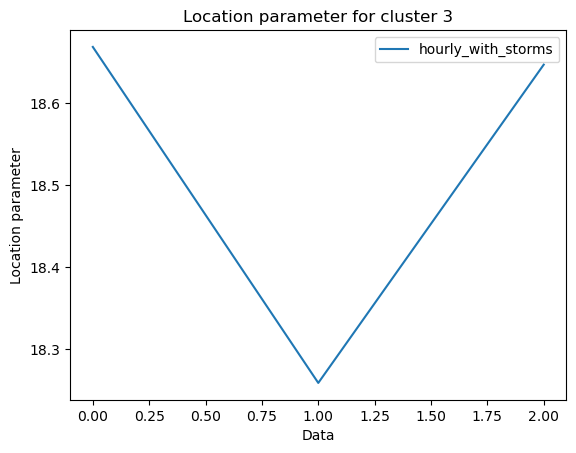

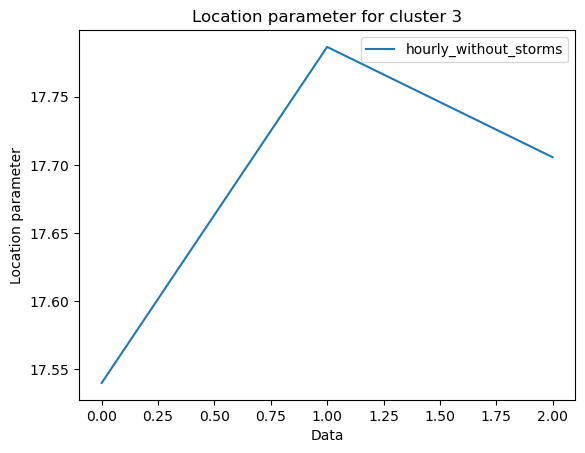

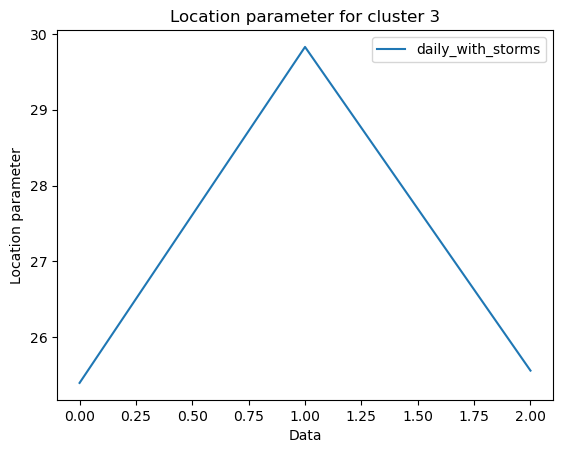

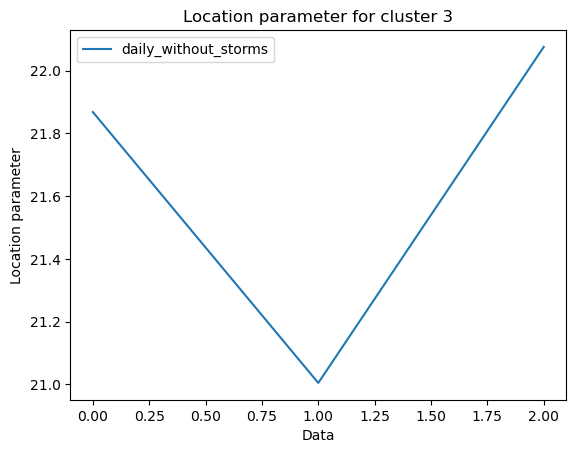

In [50]:
cluster_number = 3
mus = []
sigmas = []
xi = []
for data in all_datasets:
    data_name = data['name'].iloc[0]
    print('Cluster number:', cluster_number)
    data = data.groupby('cluster_n')
    data = data.get_group(cluster_number)['wind_speed_None']
    vivian_subset = vivian[vivian['cluster_n'] == cluster_number]['wind_speed_None']

    # Fit the GEV distribution
    shape, loc, scale = genextreme.fit(data, method="MLE")

    mus.append(loc)
    sigmas.append(scale)
    xi.append(shape)
    print("Data:", data_name)
    print(f"Shape (ξ): {shape}, Location (μ): {loc}, Scale (σ): {scale}")

# plot for each data_name the location parameter (which spans over 3 days)
plt.plot(mus[0:3], label='hourly_with_storms')
plt.legend()
plt.title(f"Location parameter for cluster {cluster_number}")
plt.xlabel("Data")
plt.ylabel("Location parameter")
plt.savefig(f'pre_processing/GEV/figures/location_parameter_{data_name[0]}.png')
plt.show()

plt.plot(mus[3:6], label='hourly_without_storms')
plt.legend()
plt.title(f"Location parameter for cluster {cluster_number}")
plt.xlabel("Data")
plt.ylabel("Location parameter")
plt.savefig(f'pre_processing/GEV/figures/location_parameter_{data_name[1]}.png')
plt.show()

plt.plot(mus[6:9], label='daily_with_storms')
plt.legend()
plt.title(f"Location parameter for cluster {cluster_number}")
plt.xlabel("Data")
plt.ylabel("Location parameter")
plt.savefig(f'pre_processing/GEV/figures/location_parameter_{data_name[2]}.png')
plt.show()

plt.plot(mus[9:], label='daily_without_storms')
plt.legend()
plt.title(f"Location parameter for cluster {cluster_number}")
plt.xlabel("Data")
plt.ylabel("Location parameter")
plt.savefig(f'pre_processing/GEV/figures/location_parameter_{data_name[3]}.png')
plt.show()



Cluster number: 3
Data: hourly_with_storms
Shape (ξ): 0.16, Location (μ): 18.67, Scale (σ): 3.4

Cluster number: 3
Data: hourly_with_storms
Shape (ξ): 0.26, Location (μ): 18.26, Scale (σ): 3.34

Cluster number: 3
Data: hourly_with_storms
Shape (ξ): 0.07, Location (μ): 18.65, Scale (σ): 2.97

Cluster number: 3
Data: hourly_without_storms
Shape (ξ): 0.21, Location (μ): 17.54, Scale (σ): 2.82

Cluster number: 3
Data: hourly_without_storms
Shape (ξ): 0.24, Location (μ): 17.79, Scale (σ): 3.23

Cluster number: 3
Data: hourly_without_storms
Shape (ξ): 0.12, Location (μ): 17.71, Scale (σ): 2.62

Cluster number: 3
Data: daily_with_storms
Shape (ξ): 0.33, Location (μ): 25.4, Scale (σ): 3.36

Cluster number: 3
Data: daily_with_storms
Shape (ξ): 2.32, Location (μ): 29.83, Scale (σ): 2.59

Cluster number: 3
Data: daily_with_storms
Shape (ξ): 0.31, Location (μ): 25.56, Scale (σ): 3.28

Cluster number: 3
Data: daily_without_storms
Shape (ξ): 0.19, Location (μ): 21.87, Scale (σ): 2.11

Cluster number

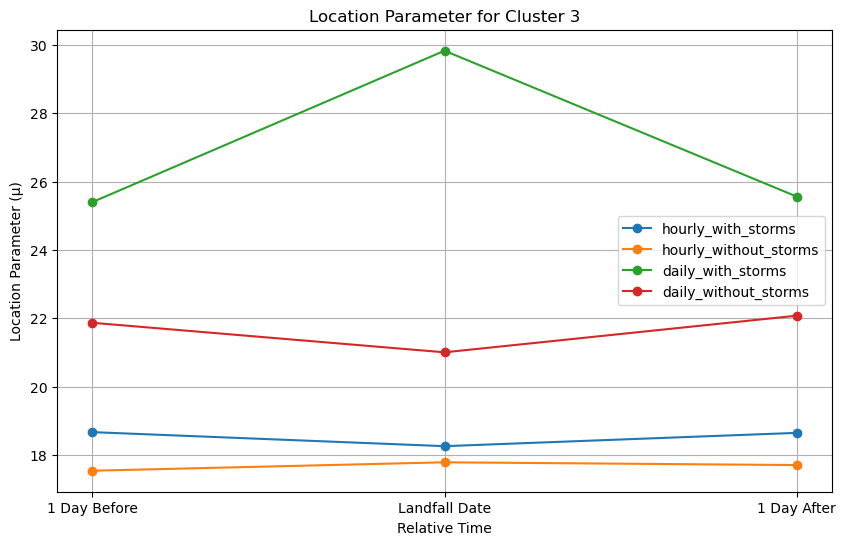

In [53]:
import matplotlib.pyplot as plt
from scipy.stats import genextreme

cluster_number = 3
mus = []
sigmas = []
xi = []

# Process each dataset
for data in all_datasets:
    data_name = data['name'].iloc[0]
    print('Cluster number:', cluster_number)
    
    # Group data by cluster and filter for the current cluster
    grouped_data = data.groupby('cluster_n')
    if cluster_number in grouped_data.groups:
        cluster_data = grouped_data.get_group(cluster_number)['wind_speed_None']
        vivian_subset = vivian[vivian['cluster_n'] == cluster_number]['wind_speed_None']

        # Fit the GEV distribution
        shape, loc, scale = genextreme.fit(cluster_data, method="MLE")
        mus.append(loc)
        sigmas.append(scale)
        xi.append(shape)
        
        print("Data:", data_name)
        print(f"Shape (ξ): {round(shape,2)}, Location (μ): {round(loc,2)}, Scale (σ): {round(scale,2)}")
        print('')
    else:
        print(f"Cluster {cluster_number} not found in dataset {data_name}")

# Define labels for each dataset group
labels = ['hourly_with_storms', 'hourly_without_storms', 'daily_with_storms', 'daily_without_storms']

# Define x-axis ticks and labels for relative time
x_ticks = [0, 1, 2]  # 0: day before, 1: landfall, 2: day after
x_labels = ["1 Day Before", "Landfall Date", "1 Day After"]

# Combined plot for all groups
plt.figure(figsize=(10, 6))

for i, label in enumerate(labels):
    start_idx = i * 3
    end_idx = start_idx + 3
    plt.plot(x_ticks, mus[start_idx:end_idx], marker='o', label=label)
    #plt.plot(x_ticks, sigmas[start_idx:end_idx], marker='o', label=label)
    #plt.plot(x_ticks, xi[start_idx:end_idx], marker='o', label=label)

# Customize x-axis
plt.xticks(ticks=x_ticks, labels=x_labels)

# Add legend, title, and axis labels
plt.legend()
plt.title(f"Location Parameter for Cluster {cluster_number}")
plt.xlabel("Relative Time")
plt.ylabel("Location Parameter (μ)")
plt.grid()

# Save and show the combined plot
plt.savefig(f'pre_processing/GEV/figures/location_parameter_cluster_{cluster_number}_relative_time.png')
plt.show()

In [ ]:
# import cluster data 
cluster_data = pd.read_csv('pre_processing/cluster/number_of_clusters/cleaned_cluster_15_v1.csv')
paths = ['hourly_with_storms', 'hourly_without_storms', 'daily_with_storms', 'daily_without_storms']
all_datasets = []
months = [1,2]
days = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31]
#for path in paths:
for month in months:
    for day in days:
        for path in paths:
            try:
                if path == 'hourly_with_storms' or path =='hourly_without_storms':
                    file_path_hourly = f'data/climatology/{path}/climatology_europe_{month}_{day}.nc'
                    #file_path_2_1 = f'data/climatology/{path}/climatology_europe_2_1.nc'
                    #file_path_2_3 = f'data/climatology/{path}/climatology_europe_2_3.nc'
                    hourly = data_processing.process_hourly_climatology(
                        file_path_hourly, cluster_data, name=path
                    )
                    all_datasets.append(hourly)
                    #hourly_2_1 = data_processing.process_hourly_climatology(
                    #    file_path_2_1, cluster_data, name=path
                    #)
                    #all_datasets.append(hourly_2_1)
                    #hourly_2_3 = data_processing.process_hourly_climatology(
                    #    file_path_2_3, cluster_data, name=path
                    #)
                    #all_datasets.append(hourly_2_3)
                elif path == 'daily_with_storms' or path =='daily_without_storms':
                    file_path_daily = f'data/climatology/{path}/climatology_europe_{month}_{day}.tif'
                    #file_path_2_1 = f'data/climatology/{path}/climatology_europe_2_1.tif'
                    #file_path_2_3 = f'data/climatology/{path}/climatology_europe_2_3.tif'

                    # Process data for daily_with_storms
                    daily = data_processing.process_daily_climatology(
                        file_path_daily, cluster_data, name=path
                    )
                    all_datasets.append(daily)
                    #daily_2_1 = data_processing.process_daily_climatology(
                    #    file_path_2_1, cluster_data, name=path
                    #)
                    #all_datasets.append(daily_2_1)
                    #daily_2_3 = data_processing.process_daily_climatology(
                    #    file_path_2_3, cluster_data, name=path
                    #)
                    #all_datasets.append(daily_2_3)
            except:
                print(f"Error processing {path} for {month}_{day}")

Error processing hourly_with_storms for 1_20
Error processing hourly_without_storms for 1_20
An error occurred: data/climatology/daily_with_storms/climatology_europe_1_20.tif: No such file or directory
Error processing daily_with_storms for 1_20
An error occurred: data/climatology/daily_without_storms/climatology_europe_1_20.tif: No such file or directory
Error processing daily_without_storms for 1_20
Error processing hourly_without_storms for 1_26


In [ ]:
import concurrent.futures
import pandas as pd

# Import cluster data
cluster_data = pd.read_csv('pre_processing/cluster/number_of_clusters/cleaned_cluster_15_v1.csv')
paths = ['hourly_with_storms', 'hourly_without_storms', 'daily_with_storms', 'daily_without_storms']
months = [1, 2]
days = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]

all_datasets = []

def process_file(path, month, day):
    """
    Process a single file based on the path, month, and day.
    Returns the processed dataset or None if an error occurs.
    """
    try:
        if path == 'hourly_with_storms' or path == 'hourly_without_storms':
            file_path_hourly = f'data/climatology/{path}/climatology_europe_{month}_{day}.nc'
            return data_processing.process_hourly_climatology(file_path_hourly, cluster_data, name=path)
        elif path == 'daily_with_storms' or path == 'daily_without_storms':
            file_path_daily = f'data/climatology/{path}/climatology_europe_{month}_{day}.tif'
            return data_processing.process_daily_climatology(file_path_daily, cluster_data, name=path)
    except Exception as e:
        print(f"Error processing {path} for {month}_{day}: {e}")
        return None

# Use ThreadPoolExecutor or ProcessPoolExecutor for parallel processing
with concurrent.futures.ThreadPoolExecutor() as executor:
    # Submit all tasks to the executor
    futures = [
        executor.submit(process_file, path, month, day)
        for path in paths
        for month in months
        for day in days
    ]

    # Collect results as they are completed
    for future in concurrent.futures.as_completed(futures):
        result = future.result()
        if result is not None:
            all_datasets.append(result)

# all_datasets now contains all the processed datasets

Error processing hourly_with_storms for 1_11: [Errno -51] NetCDF: Unknown file format: b'/Users/fabienaugsburger/Documents/GitHub/master-project-cleaned/data/climatology/hourly_with_storms/climatology_europe_1_11.nc'
Error processing hourly_with_storms for 1_13: [Errno -51] NetCDF: Unknown file format: b'/Users/fabienaugsburger/Documents/GitHub/master-project-cleaned/data/climatology/hourly_with_storms/climatology_europe_1_13.nc'
Error processing hourly_with_storms for 1_2: [Errno -51] NetCDF: Unknown file format: b'/Users/fabienaugsburger/Documents/GitHub/master-project-cleaned/data/climatology/hourly_with_storms/climatology_europe_1_2.nc'
Error processing hourly_with_storms for 1_12: [Errno -51] NetCDF: Unknown file format: b'/Users/fabienaugsburger/Documents/GitHub/master-project-cleaned/data/climatology/hourly_with_storms/climatology_europe_1_12.nc'
Error processing hourly_with_storms for 1_14: [Errno -51] NetCDF: Unknown file format: b'/Users/fabienaugsburger/Documents/GitHub/mast

In [2]:
def process_file(path, month, day):
    """
    Process a single file based on the path, month, and day.
    Returns the processed dataset or None if an error occurs.
    """
    try:
        if path == 'hourly_with_storms' or path == 'hourly_without_storms':
            file_path_hourly = f'data/climatology/{path}/climatology_europe_{month}_{day}.nc'
            return data_processing.process_hourly_climatology(file_path_hourly, cluster_data, name=f'{path}_{month}_{day}')
        elif path == 'daily_with_storms' or path == 'daily_without_storms':
            file_path_daily = f'data/climatology/{path}/climatology_europe_{month}_{day}.tif'
            return data_processing.process_daily_climatology(file_path_daily, cluster_data, name=f'{path}_{month}_{day}')
    except Exception as e:
        print(f"Error processing {path} for {month}_{day}: {e}")
        return None

In [ ]:
import dask
from dask import delayed, compute
import pandas as pd
from tqdm import tqdm

# Import cluster data
cluster_data = pd.read_csv('pre_processing/cluster/number_of_clusters/cleaned_cluster_15_v1.csv')
paths = ['hourly_with_storms', 'hourly_without_storms', 'daily_with_storms', 'daily_without_storms']
months = [1, 2]
days = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]

all_datasets = []

tasks = []
for path in paths:
    for month in months:
        for day in tqdm(days):
            tasks.append(delayed(process_file)(path, month, day))

results = compute(*tasks)
all_datasets = [result for result in results if result is not None]

100%|██████████| 31/31 [00:00<00:00, 28107.10it/s]


Error processing hourly_with_storms for 2_28: [Errno -51] NetCDF: Unknown file format: b'/Users/fabienaugsburger/Documents/GitHub/master-project-cleaned/data/climatology/hourly_with_storms/climatology_europe_2_28.nc'Error processing hourly_with_storms for 1_27: [Errno -51] NetCDF: Unknown file format: b'/Users/fabienaugsburger/Documents/GitHub/master-project-cleaned/data/climatology/hourly_with_storms/climatology_europe_1_27.nc'
Error processing hourly_with_storms for 1_13: [Errno -51] NetCDF: Unknown file format: b'/Users/fabienaugsburger/Documents/GitHub/master-project-cleaned/data/climatology/hourly_with_storms/climatology_europe_1_13.nc'

Error processing hourly_with_storms for 2_14: [Errno 2] No such file or directory: b'/Users/fabienaugsburger/Documents/GitHub/master-project-cleaned/data/climatology/hourly_with_storms/climatology_europe_2_14.nc'
Error processing hourly_with_storms for 2_31: [Errno 2] No such file or directory: b'/Users/fabienaugsburger/Documents/GitHub/master-pro

In [64]:
from joblib import Parallel, delayed

# Import cluster data
cluster_data_original = pd.read_csv('pre_processing/cluster/number_of_clusters/cleaned_cluster_15_v1.csv')
path_hourly_with = ['hourly_with_storms']
path_hourly_without = ['hourly_without_storms']
path_daily_with = ['daily_with_storms']
path_daily_without = ['daily_without_storms']
months = [1, 2, 3]
days = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]

datasets_hourly_with = []
datasets_hourly_without = []
datasets_daily_with = []
datasets_daily_without = []

results = Parallel(n_jobs=-1)(
    delayed(data_processing.process_file)(path, month, day, cluster_data_original)
    for path in path_hourly_with
    for month in months
    for day in days
)
datasets_hourly_with = [result for result in results if result is not None]
results = []
results = Parallel(n_jobs=-1)(
    delayed(data_processing.process_file)(path, month, day, cluster_data_original)
    for path in path_hourly_without
    for month in months
    for day in days
)
datasets_hourly_without = [result for result in results if result is not None]
results = []
results = Parallel(n_jobs=-1)(
    delayed(data_processing.process_file)(path, month, day, cluster_data_original)
    for path in path_daily_with
    for month in months
    for day in days
)
datasets_daily_with = [result for result in results if result is not None]
results = []
results = Parallel(n_jobs=-1)(
    delayed(data_processing.process_file)(path, month, day, cluster_data_original)
    for path in path_daily_without
    for month in months
    for day in days
)
datasets_daily_without = [result for result in results if result is not None]

Error processing hourly_with_storms for 1_20: [Errno 2] No such file or directory: b'/Users/fabienaugsburger/Documents/GitHub/master-project-cleaned/data/climatology/hourly_with_storms/climatology_europe_1_20.nc'
Error processing hourly_with_storms for 2_5: [Errno 2] No such file or directory: b'/Users/fabienaugsburger/Documents/GitHub/master-project-cleaned/data/climatology/hourly_with_storms/climatology_europe_2_5.nc'
Error processing hourly_with_storms for 2_10: [Errno 2] No such file or directory: b'/Users/fabienaugsburger/Documents/GitHub/master-project-cleaned/data/climatology/hourly_with_storms/climatology_europe_2_10.nc'
Error processing hourly_with_storms for 2_14: [Errno 2] No such file or directory: b'/Users/fabienaugsburger/Documents/GitHub/master-project-cleaned/data/climatology/hourly_with_storms/climatology_europe_2_14.nc'
Error processing hourly_with_storms for 2_30: [Errno 2] No such file or directory: b'/Users/fabienaugsburger/Documents/GitHub/master-project-cleaned/d

In [49]:
comparison = datasets_hourly_with[0] == datasets_hourly_without[0]
differences = comparison[~comparison]
print(differences.index)

RangeIndex(start=0, stop=223584, step=1)


Data: hourly_with_storms_1_1
Data: hourly_with_storms_1_2
Data: hourly_with_storms_1_3
Data: hourly_with_storms_1_4
Data: hourly_with_storms_1_5
Data: hourly_with_storms_1_6
Data: hourly_with_storms_1_7
Data: hourly_with_storms_1_8
Data: hourly_with_storms_1_9
Data: hourly_with_storms_1_10
Data: hourly_with_storms_1_11
Data: hourly_with_storms_1_12
Data: hourly_with_storms_1_13
Data: hourly_with_storms_1_14
Data: hourly_with_storms_1_15
Data: hourly_with_storms_1_16
Data: hourly_with_storms_1_17
Data: hourly_with_storms_1_18
Data: hourly_with_storms_1_19
Data: hourly_with_storms_1_21
Data: hourly_with_storms_1_22
Data: hourly_with_storms_1_23
Data: hourly_with_storms_1_24
Data: hourly_with_storms_1_25
Data: hourly_with_storms_1_26
Data: hourly_with_storms_1_27
Data: hourly_with_storms_1_28
Data: hourly_with_storms_1_29
Data: hourly_with_storms_1_30
Data: hourly_with_storms_1_31
Data: hourly_with_storms_2_1
Data: hourly_with_storms_2_2
Data: hourly_with_storms_2_3
Data: hourly_with_stor

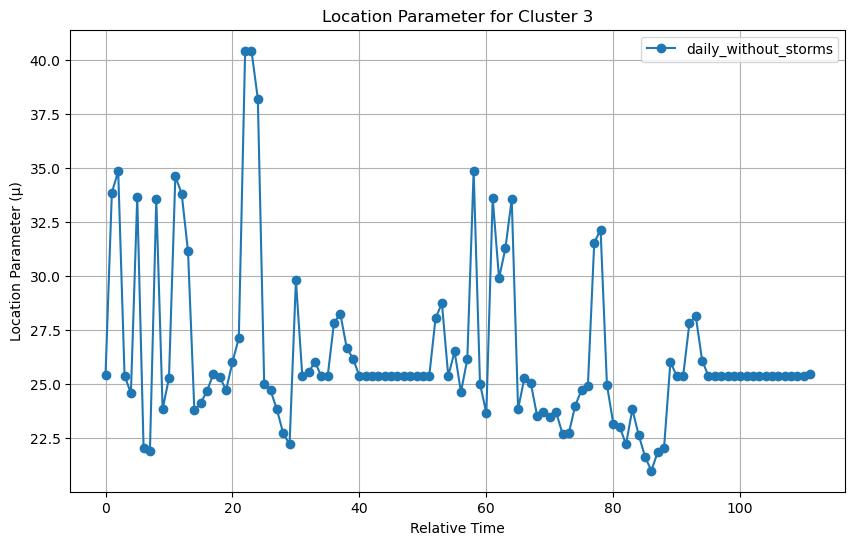

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import genextreme

cluster_number = 3
mus = []
sigmas = []
xi = []

mus_hourly_with_storms = []
sigmas_hourly_with_storms = []
xi_hourly_with_storms = []

mus_hourly_without_storms = []
sigmas_hourly_without_storms = []
xi_hourly_without_storms = []

mus_daily_with_storms = []
sigmas_daily_with_storms = []
xi_daily_with_storms = []

mus_daily_without_storms = []
sigmas_daily_without_storms = []
xi_daily_without_storms = []

# Process each dataset
for data in all_datasets:
    data_name = data['name'].iloc[0]
    print("Data:", data_name)

    #print('Cluster number:', cluster_number)
    
    # Group data by cluster and filter for the current cluster
    grouped_data = data.groupby('cluster_n')

    if data_name.startswith('hourly_without_storms'):
        cluster_data = grouped_data.get_group(cluster_number)['wind_speed_None']
        vivian_subset = vivian[vivian['cluster_n'] == cluster_number]['wind_speed_None']

        # Fit the GEV distribution
        shape, loc, scale = genextreme.fit(cluster_data, method="MLE")

        mus_hourly_without_storms.append(loc)
        sigmas_hourly_without_storms.append(scale)
        xi_hourly_without_storms.append(shape)

    elif data_name.startswith('hourly_with_storms'):
        cluster_data = grouped_data.get_group(cluster_number)['wind_speed_None']
        vivian_subset = vivian[vivian['cluster_n'] == cluster_number]['wind_speed_None']

        # Fit the GEV distribution
        shape, loc, scale = genextreme.fit(cluster_data, method="MLE")

        mus_hourly_with_storms.append(loc)
        sigmas_hourly_with_storms.append(scale)
        xi_hourly_with_storms.append(shape)

    elif data_name.startswith('daily_with'):
        cluster_data = grouped_data.get_group(cluster_number)['wind_speed_None']
        vivian_subset = vivian[vivian['cluster_n'] == cluster_number]['wind_speed_None']

        # Fit the GEV distribution
        shape, loc, scale = genextreme.fit(cluster_data, method="MLE")

        mus_daily_with_storms.append(loc)
        sigmas_daily_with_storms.append(scale)
        xi_daily_with_storms.append(shape)

    elif data_name.startswith('daily_without'):
        cluster_data = grouped_data.get_group(cluster_number)['wind_speed_None']
        vivian_subset = vivian[vivian['cluster_n'] == cluster_number]['wind_speed_None']

        # Fit the GEV distribution
        shape, loc, scale = genextreme.fit(cluster_data, method="MLE")

        mus_daily_without_storms.append(loc)
        sigmas_daily_without_storms.append(scale)
        xi_daily_without_storms.append(shape)
        
    else:
        print(f"Cluster {cluster_number} not found in dataset {data_name}")

'''    if cluster_number in grouped_data.groups:
        cluster_data = grouped_data.get_group(cluster_number)['wind_speed_None']
        vivian_subset = vivian[vivian['cluster_n'] == cluster_number]['wind_speed_None']

        # Fit the GEV distribution
        shape, loc, scale = genextreme.fit(cluster_data, method="MLE")

        mus.append(loc)
        sigmas.append(scale)
        xi.append(shape)
        
        print("Data:", data_name)
        print(f"Shape (ξ): {round(shape,2)}, Location (μ): {round(loc,2)}, Scale (σ): {round(scale,2)}")
        print('')
'''

'''# Define labels for each dataset group
labels = ['hourly_with_storms', 'hourly_without_storms', 'daily_with_storms', 'daily_without_storms']

# Define x-axis ticks and labels for relative time
x_ticks = [0, 1, 2]  # 0: day before, 1: landfall, 2: day after
x_labels = ["1 Day Before", "Landfall Date", "1 Day After"]'''

# Combined plot for all groups
plt.figure(figsize=(10, 6))

#for i in range (0, len(mus_hourly_with_storms)):

plt.plot(mus_daily_with_storms, marker='o', label=label)
    #plt.plot(x_ticks, sigmas[start_idx:end_idx], marker='o', label=label)
    #plt.plot(x_ticks, xi[start_idx:end_idx], marker='o', label=label)

# Customize x-axis
#plt.xticks(ticks=x_ticks, labels=x_labels)

# Add legend, title, and axis labels
plt.legend()
plt.title(f"Location Parameter for Cluster {cluster_number}")
plt.xlabel("Relative Time")
plt.ylabel("Location Parameter (μ)")
plt.grid()

# Save and show the combined plot
plt.savefig(f'pre_processing/GEV/figures/location_parameter_cluster_{cluster_number}_relative_time.png')
plt.show()

In [72]:
cluster_number = 3
mus_daily_with_storms = []
sigmas_daily_with_storms = []
xi_daily_with_storms = []
mus_daily_without_storms = []
sigmas_daily_without_storms = []
xi_daily_without_storms = []
mus_hourly_with_storms = []
sigmas_hourly_with_storms = []
xi_hourly_with_storms = []
mus_hourly_without_storms = []
sigmas_hourly_without_storms = []
xi_hourly_without_storms = []

vivian = data_processing.process_daily_climatology('data/time_series_rasters_storms_15h/5_VIVIAN.tif', 
                                                   cluster_data_original, 
                                                   'VIVIAN')

# Process each dataset
for data in datasets_daily_without:
    data_name = data['name'].iloc[0]
    print("Data:", data_name)

    #print('Cluster number:', cluster_number)
    
    # Group data by cluster and filter for the current cluster
    grouped_data = data.groupby('cluster_n')
    cluster_data = grouped_data.get_group(cluster_number)['wind_speed_None']
    vivian_subset = vivian[vivian['cluster_n'] == cluster_number]['wind_speed_None']

    # Fit the GEV distribution
    shape, loc, scale = weibull_min.fit(cluster_data, method="MLE")

    mus_daily_with_storms.append(loc)
    sigmas_daily_with_storms.append(scale)
    xi_daily_with_storms.append(shape)

# Process each dataset
for data in datasets_daily_with:
    data_name = data['name'].iloc[0]
    print("Data:", data_name)

    #print('Cluster number:', cluster_number)
    
    # Group data by cluster and filter for the current cluster
    grouped_data = data.groupby('cluster_n')
    cluster_data = grouped_data.get_group(cluster_number)['wind_speed_None']
    vivian_subset = vivian[vivian['cluster_n'] == cluster_number]['wind_speed_None']

    # Fit the GEV distribution
    shape, loc, scale = weibull_min.fit(cluster_data, method="MLE")

    mus_daily_without_storms.append(loc)
    sigmas_daily_without_storms.append(scale)
    xi_daily_without_storms.append(shape)

# Process each dataset
for data in datasets_hourly_with:
    data_name = data['name'].iloc[0]
    print("Data:", data_name)

    #print('Cluster number:', cluster_number)
    
    # Group data by cluster and filter for the current cluster
    grouped_data = data.groupby('cluster_n')
    cluster_data = grouped_data.get_group(cluster_number)['wind_speed_None']
    vivian_subset = vivian[vivian['cluster_n'] == cluster_number]['wind_speed_None']

    # Fit the GEV distribution
    shape, loc, scale = weibull_min.fit(cluster_data, method="MLE")

    mus_hourly_with_storms.append(loc)
    sigmas_hourly_with_storms.append(scale)
    xi_hourly_with_storms.append(shape)

# Process each dataset
for data in datasets_hourly_without:
    data_name = data['name'].iloc[0]
    print("Data:", data_name)

    #print('Cluster number:', cluster_number)
    
    # Group data by cluster and filter for the current cluster
    grouped_data = data.groupby('cluster_n')
    cluster_data = grouped_data.get_group(cluster_number)['wind_speed_None']
    vivian_subset = vivian[vivian['cluster_n'] == cluster_number]['wind_speed_None']

    # Fit the GEV distribution
    shape, loc, scale = weibull_min.fit(cluster_data, method="MLE")

    mus_hourly_without_storms.append(loc)
    sigmas_hourly_without_storms.append(scale)
    xi_hourly_without_storms.append(shape)

Data: daily_without_storms_1_1
Data: daily_without_storms_1_2
Data: daily_without_storms_1_3
Data: daily_without_storms_1_4
Data: daily_without_storms_1_5
Data: daily_without_storms_1_6
Data: daily_without_storms_1_7
Data: daily_without_storms_1_8
Data: daily_without_storms_1_9
Data: daily_without_storms_1_10
Data: daily_without_storms_1_11
Data: daily_without_storms_1_12
Data: daily_without_storms_1_13
Data: daily_without_storms_1_14
Data: daily_without_storms_1_15
Data: daily_without_storms_1_16
Data: daily_without_storms_1_17
Data: daily_without_storms_1_18
Data: daily_without_storms_1_19
Data: daily_without_storms_1_21
Data: daily_without_storms_1_22
Data: daily_without_storms_1_23
Data: daily_without_storms_1_24
Data: daily_without_storms_1_25
Data: daily_without_storms_1_26
Data: daily_without_storms_1_27
Data: daily_without_storms_1_28
Data: daily_without_storms_1_29
Data: daily_without_storms_1_30
Data: daily_without_storms_1_31
Data: daily_without_storms_2_1
Data: daily_withou

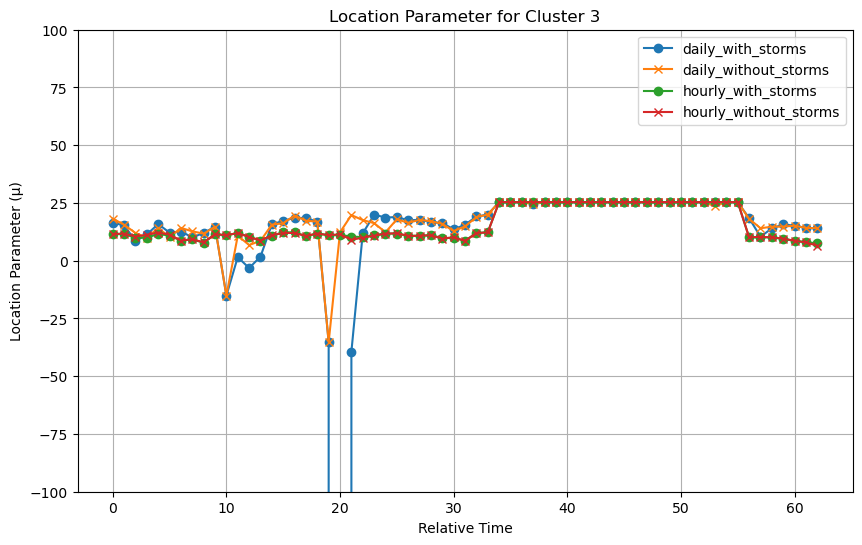

In [79]:
plt.figure(figsize=(10, 6))
plt.plot(mus_daily_with_storms, marker='o')
plt.plot(mus_daily_without_storms, marker='x')
plt.plot(mus_hourly_with_storms, marker='o')
plt.plot(mus_hourly_without_storms, marker='x')
# Customize x-axis
#plt.xticks(ticks=x_ticks, labels=x_labels)

# Add legend, title, and axis labels
plt.legend(['daily_with_storms', 'daily_without_storms', 'hourly_with_storms', 'hourly_without_storms'])
plt.title(f"Location Parameter for Cluster {cluster_number}")
plt.xlabel("Relative Time")
plt.ylabel("Location Parameter (μ)")
plt.ylim(-100, 100)
plt.grid()
plt.show()

In [80]:
datasets_daily_with[40]

,wind_speed_None,longitude,latitude,cluster_n,name
147,28.389998,24.75,71.00,10.0,daily_with_storms_2_13
350,27.795845,23.25,70.75,10.0,daily_with_storms_2_13
355,32.727441,24.50,70.75,10.0,daily_with_storms_2_13
356,32.392375,24.75,70.75,10.0,daily_with_storms_2_13
357,33.194993,25.00,70.75,10.0,daily_with_storms_2_13
...,...,...,...,...,...
30033,25.989484,24.50,35.25,13.0,daily_with_storms_2_13
30034,26.485879,24.75,35.25,13.0,daily_with_storms_2_13
30035,25.373651,25.00,35.25,13.0,daily_with_storms_2_13
30243,25.373651,24.75,35.00,13.0,daily_with_storms_2_13


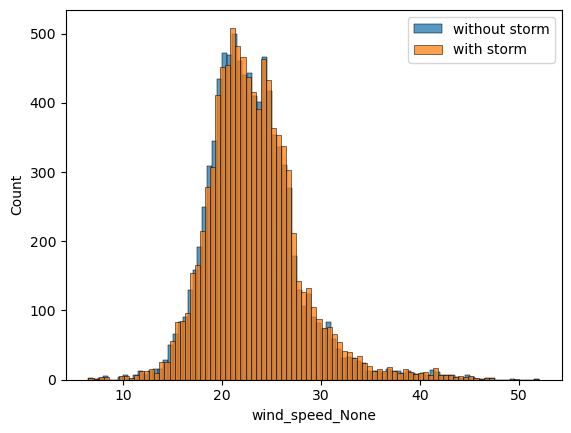

In [91]:
import seaborn
#seaborn.histplot(datasets_daily_without[40]['wind_speed_None'])
seaborn.histplot(datasets_daily_without[30]['wind_speed_None'], label='without storm')
seaborn.histplot(datasets_daily_with[30]['wind_speed_None'], label='with storm')
plt.legend()

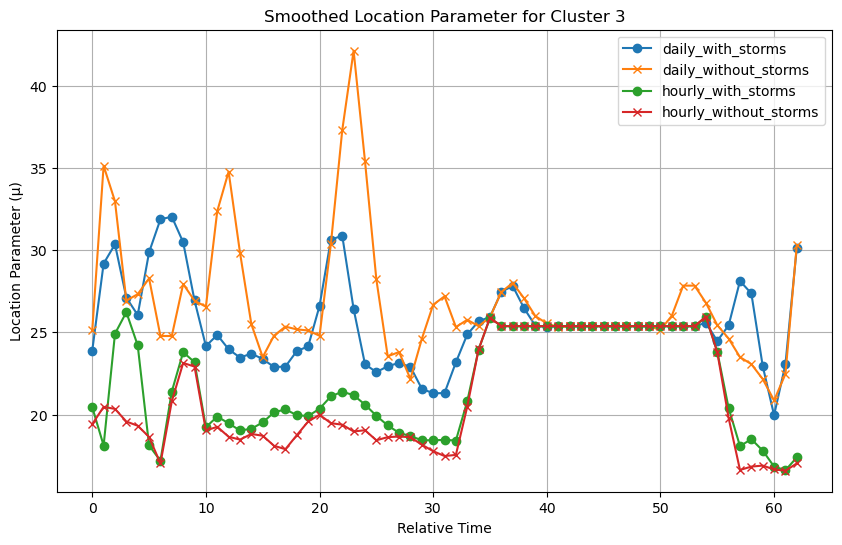

In [67]:
# plot a smoothed version of the location parameter
from scipy.signal import savgol_filter

# Define the window size and polynomial order for the Savitzky-Golay filter
window_size = 5
poly_order = 3

# Apply the Savitzky-Golay filter to the location parameter
mus_daily_with_storms_smoothed = savgol_filter(mus_daily_with_storms, window_size, poly_order)
mus_daily_without_storms_smoothed = savgol_filter(mus_daily_without_storms, window_size, poly_order)
mus_hourly_with_storms_smoothed = savgol_filter(mus_hourly_with_storms, window_size, poly_order)
mus_hourly_without_storms_smoothed = savgol_filter(mus_hourly_without_storms, window_size, poly_order)

# Plot the smoothed location parameter
plt.figure(figsize=(10, 6))
plt.plot(mus_daily_with_storms_smoothed, marker='o')
plt.plot(mus_daily_without_storms_smoothed, marker='x')
plt.plot(mus_hourly_with_storms_smoothed, marker='o')
plt.plot(mus_hourly_without_storms_smoothed, marker='x')

# Add legend, title, and axis labels
plt.legend(['daily_with_storms', 'daily_without_storms', 'hourly_with_storms', 'hourly_without_storms'])
plt.title(f"Smoothed Location Parameter for Cluster {cluster_number}")
plt.xlabel("Relative Time")
plt.ylabel("Location Parameter (μ)")
plt.grid()
plt.show()

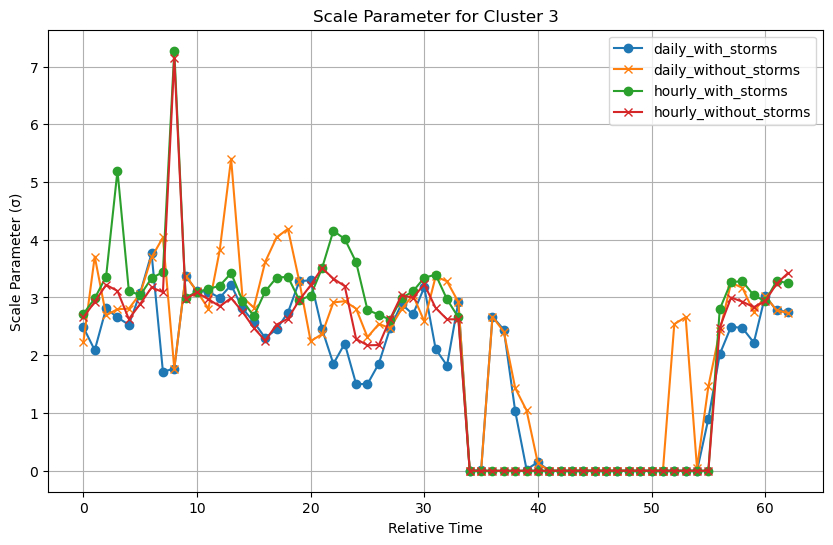

In [68]:
# Do the same for the scale parameter

plt.figure(figsize=(10, 6))
plt.plot(sigmas_daily_with_storms, marker='o')
plt.plot(sigmas_daily_without_storms, marker='x')
plt.plot(sigmas_hourly_with_storms, marker='o')
plt.plot(sigmas_hourly_without_storms, marker='x')
# Customize x-axis
#plt.xticks(ticks=x_ticks, labels=x_labels)

# Add legend, title, and axis labels
plt.legend(['daily_with_storms', 'daily_without_storms', 'hourly_with_storms', 'hourly_without_storms'])
plt.title(f"Scale Parameter for Cluster {cluster_number}")
plt.xlabel("Relative Time")
plt.ylabel("Scale Parameter (σ)")
plt.grid()
plt.show()

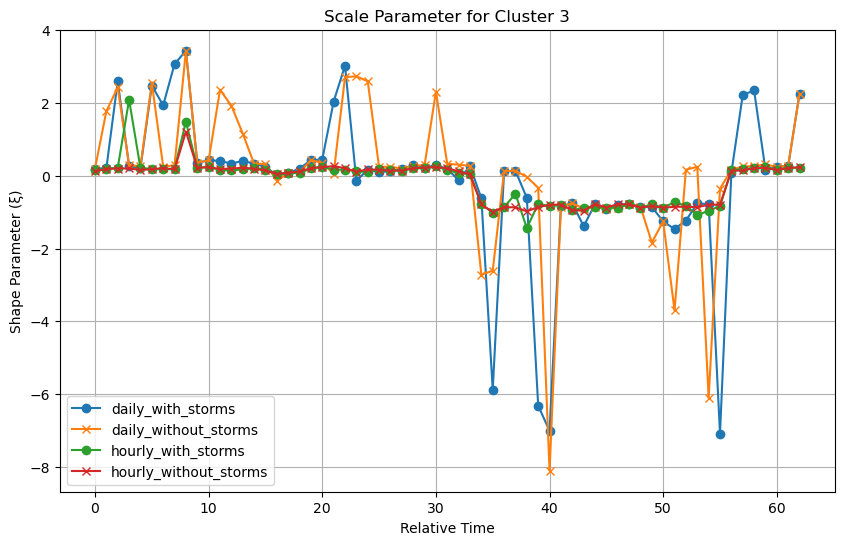

In [69]:
# Do the same for the shape parameter

plt.figure(figsize=(10, 6))
plt.plot(xi_daily_with_storms, marker='o')
plt.plot(xi_daily_without_storms, marker='x')
plt.plot(xi_hourly_with_storms, marker='o')
plt.plot(xi_hourly_without_storms, marker='x')
# Customize x-axis
#plt.xticks(ticks=x_ticks, labels=x_labels)

# Add legend, title, and axis labels
plt.legend(['daily_with_storms', 'daily_without_storms', 'hourly_with_storms', 'hourly_without_storms'])
plt.title(f"Scale Parameter for Cluster {cluster_number}")
plt.xlabel("Relative Time")
plt.ylabel("Shape Parameter (ξ)")
plt.grid()
plt.show()

Python profiling